In [1]:
import sys

sys.path.append("..")

import jax

jax.config.update("jax_platform_name", "cpu")

import numpyro

numpyro.set_host_device_count(4)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

from datetime import datetime

from pymc_experimental.statespace.core.statespace import PyMCStateSpace
import pytensor.tensor as pt
import pymc as pm

In [2]:
matrix_names = [
    "initial_state",
    "initial_state_cov",
    "state_intercept",
    "obs_intercept",
    "transition",
    "design",
    "selection",
    "obs_cov",
    "state_cov",
]


def print_model_ssm(mod):
    nice_heading = f'{"name":<20}{"__repr__":<50}{"shape":<10}{"value":<20}'
    print(nice_heading)
    print("=" * len(nice_heading))
    for name in matrix_names:
        repr_ = str(mod.ssm[name])
        shape = str(mod.ssm[name].type.shape)
        value = mod.ssm[name].eval()
        value = str(value).replace("\n ", "\n" + " " * 81)
        print(f"{name:<20}{repr_:<50}{shape:<10}{value:<20}")
        print("-" * len(nice_heading))

In [3]:
seed = sum(map(ord, "custom statespace model"))
rng = np.random.default_rng(seed)

# Why use the `PyMCStateSpace` class

The statespace module is designed to make it easy for users to create their own statespace models. At its core, a statspace model is just a system of two linear equatons:

$$\begin{align} x_{t+1} &= A_t x_t + c_t + R_t \varepsilon_t, & \varepsilon_t &\sim N(0, Q_t) \\
y_t &= Z_t x_t + d_t + \eta_t, & \eta_t &\sim N(0, H_t) \\
x_0 &\sim N(\bar x, P)\end{align}$$

Despite just being 2 equations (plus an inital state distribution), there is a need for some machinery to abstract away the matrices, and let users focus on parameters when modeling. As an example, here is an AR(3) model in statespace form:

$$\begin{align} \begin{bmatrix} x_t \\ x_{t-1} \\ x_{t-2} \end{bmatrix} &= \begin{bmatrix} \rho_1 & \rho_2 & \rho_3 \\ 1 & 0 & 0 \\ 0 & 1 & 0 \end{bmatrix} \begin{bmatrix} x_{t-1} \\ x_{t-2} \\ x_{t-3} \end{bmatrix} + \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} \varepsilon_t, & \varepsilon_t &\sim N \left (0, \begin{bmatrix}\sigma^2_x\end{bmatrix} \right) \\
 y_t &= \begin{bmatrix} 1 & 0 & 0 \end{bmatrix} \begin{bmatrix}x_t \\ x_{t-1} \\ x_{t-2} \end{bmatrix} \end{align}$$
 
Although the model has only 4 parameters, $\theta = \begin{bmatrix} \rho_1 & \rho_2 & \rho_3 & \sigma^2_x \end{bmatrix}$, there is a good amount of additional "structure" that needs to be dealt with. The parameters need to be slotted into the correct locations in $T$ and $Q$, constants need to be inserted into $T$, $R$, and $Z$, and the fact that $\eta_t$ is not present needs to be handled.

These details present a significant learning curve for a user, who just wants to estimate 4 parameters and model some data. The purpose of the `PyMCStateSpace` class is to protect users from these messy details, and allow them to put their focus where it belongs.


# Making a new `PyMCStateSpace` model

Nevertheless, if you want to make your own spacespace model, the `PyMCStateSpace` class is designed to allow users to easily implement new models. A subclass of `PyMCStateSpace` **must** overload 3 important methods/properties:

1. `__init__`.
2. `param_names`
3. `update`

In addition to these 3, there are several additional properties that can be implemented. These are optional, and are related to automatically generating coords and dims for a PyMC model. They include:

4. `param_info`
5. `state_names`
6. `observed_states`
7. `shock_names`
8. `coords`
9. `param_dims`

We will return to these optional properties later in the notebook. First, let's see what you **must** do to make a statespace model by implementing the AR(3) model described above.

## The AutoRegressiveThree class

The first thing to implement is the `__init__` method. The main purpose of the `__init__` method is create two supporting objects and attach them to your `PyMCStateSpace`. The first is a `PytensorRepresentation` object, and the second is a `KalmanFilter`. 

* The `PytensorRepresentation` is attached to your statepace as `ssm` (for "State Space Model"). It holds all the vectors and matrices associated with your statespace. 
    * In order to initialize all these objects, the `PytensorRepresentation` needs to know their shapes. Three numbers define all the shapes of all the objects in the system: `k_states`, `k_posdef`, and `k_endog`. 
        * `k_states` is the total number of hidden states in the system -- that's the shape of the $x_t$ vector. In our case, it's 3.
        * `k_posdef` is the total number of shock processes in the system. It's called "posdef" for "positive definite", because it refers to the rank of the matrix $RQR^T$ (which is the covariance matrix of $\varepsilon_t$ if you ues the rule of affine transformations of multivariate normals). Anyway, it's 1 in our case.
        * `k_endog` is the total number of observed variables -- that's the shape of the $y_t$ vector. In our case it's 1.      
* The `KalmanFilter` is a recursive algorithm that infers the values of the hidden states and the probably of the data. You can pass a keyword argument `filter_type` to `super().__init__()` to get different types of filters, but the default works great.

Our model isn't going to have any bells or whistles, so we just hard-code the three shape arguments and pass them to the superclass constructor. 

### The `__init__` method

In [4]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

This already works, and we can look at the `PytensorRepresentation` and `KalmanFilter` that have been created for us.

In [5]:
ar3 = AutoRegressiveThree()

In [6]:
ar3.ssm

In [7]:
ar3.kalman_filter

To see indivdual matrices inside the `PytensorRepresentation`, you ask for them by name. The matrix names are:

* $\bar x$ - `initial_state`
* $P$ - `initial_state_cov`
* $c$ - `state_intercept`
* $d$ - `obs_intercept`
* $T$ - `transition`
* $Z$ - `design`
* $R$ - `selection`
* $H$ - `obs_cov`
* $Q$ - `state_cov`

In [8]:
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state{[0. 0. 0.]}                         (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0. 0. 0. ... 0. 0. 0.]]}      (3, 3)    [[0. 0. 0.]
                                                                                 [0. 0. 0.]
                                                                                 [0. 0. 0.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------

As you can see, all of the matrices have the right shapes, but they're initialized with a bunch of zeros. A second function of the `__init__` method is to set constants in these matrices.

Referring back to the equations above, we need to put `1` into some locations of `transition`, `selection`, and `design`. This is very easy to do: after providing a matrix name, you are allowed to index into a matrix and set values by using direct assignment, just like a normal numpy array.

In [9]:
ar3.ssm["transition", :, :] = np.eye(3, k=-1)
ar3.ssm["selection", 0, 0] = 1
ar3.ssm["design", 0, 0] = 1

In [10]:
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state{[0. 0. 0.]}                         (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0. 0. 0. ... 0. 0. 0.]]}      (3, 3)    [[0. 0. 0.]
                                                                                 [0. 0. 0.]
                                                                                 [0. 0. 0.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------

As you can see, values were assigned in all the matrices, as expected. Let's go back and edit the class to do this on construction

In [11]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

Now everything intializes correctly.

In [12]:
ar3 = AutoRegressiveThree()
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state{[0. 0. 0.]}                         (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov{[[0. 0. 0. ... 0. 0. 0.]]}      (3, 3)    [[0. 0. 0.]
                                                                                 [0. 0. 0.]
                                                                                 [0. 0. 0.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
----------------

### The `param_names` property

After `__init__`, the second thing we need to do is set the `param_names` property. This property is a critical bridge between a PyMC model and a PyMCStateSpace model. To understand why, we need to take a look at where we are going to go.

The `build_statespace_graph` method of a `PyMCStateSpace` instance is called inside a `pm.Model` block. Calling this method will do three things:

1. Register the observed data that will be used to perform Kalman Filtering.
2. Seek out and organize the priors associated with model parameters, by calling the `_gather_required_random_variables` method.
3. Put the RVs where they belong in the statespace matrices by calling the `update` method.

`param_names` is what allows step 2 to happen. The names returned by the property `param_names` will be sought out in the `pm.Model` currently on the context stack. It will then assemble a **flat** vector of parameters **in the order of the names returned by `param_names`**. 

Let's implement the property, then see how it works.

In [13]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

    @property
    def param_names(self):
        return ["x0", "P0", "ar_params", "sigma_x"]

In addition to the two parameters the model needs (`ar_params` for $\rho_1, \rho_2, \rho_3$, and `\sigma_x` for $sigma_x$), I also decided to force the user provide random variables for the initial state and covariance. Of course, we can also provide deterministic values via `pm.Determisitic` too. 

Let's see how the `param_names` are used by `_gather_required_random_variables`. For illustration purposes, I'll set everything to be deterministic, so there's no confusion about what is going where.

In [14]:
ar3 = AutoRegressiveThree()
with pm.Model() as mod:
    x0 = pm.Deterministic("x0", pt.arange(3))
    P0 = pm.Deterministic("P0", pt.eye(3) * 10)
    ar_params = pm.Deterministic("ar_params", pt.as_tensor_variable([10, 11, 12]))
    sigma_x = pm.Deterministic("sigma_x", pt.as_tensor_variable([13]))
    theta = ar3._gather_required_random_variables()

As you can see, the `theta` vector created by `ar3._gather_requried_random_variables()` has length 3 + 9 + 3 + 1 = 16, and has been created via something like `concatenate([name.ravel() for name in ar3.param_names])`. 

In [15]:
print(theta.shape.eval())
print(theta.eval())

[16]
[ 0.  1.  2. 10.  0.  0.  0. 10.  0.  0.  0. 10. 10. 11. 12. 13.]


Also, if no RV for a given `param_name` is found, an error will be raised. The names have to match exactly, and all names need to be present. 

In [16]:
ar3 = AutoRegressiveThree()
with pm.Model() as mod:
    x0 = pm.Deterministic("x0", pt.arange(3))
    #     P0 = pm.Deterministic('P0', pt.eye(3) * 10)
    ar_params = pm.Deterministic("ar_params", pt.as_tensor_variable([10, 11, 12]))
    sigma_x = pm.Deterministic("sigma_x", pt.as_tensor_variable([13]))
    theta = ar3._gather_required_random_variables()

ValueError: The following required model parameters were not found in the PyMC model: P0

### The `update` method

The last required method to implement is `update`. `update` takes in `theta` (the one constructed by `_gather_required_random_variables()`), plus `**kwargs`, and puts all the RVs into their correct places in the statespace model objects.

Inside `update`, you will need to chop up the `theta` vector, reshaping where necessary, and assign things where they belong. Here is the AutoRegressiveThree model one more time, now with an `update` implementation.

In [17]:
class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

    @property
    def param_names(self):
        return ["x0", "P0", "ar_params", "sigma_x"]

    def update(self, theta, **kwargs):
        x0_params = theta[:3]
        P0_params = theta[3:12]
        ar_params = theta[12:15]
        sigma_x = theta[15]

        self.ssm["initial_state", :] = x0_params
        self.ssm["initial_state_cov", :, :] = P0_params.reshape((3, 3))
        self.ssm["transition", 0, :] = ar_params
        self.ssm["state_cov", 0, 0] = sigma_x

We are now ready to call `build_statespace_graph` inside a PyMC model block to estimate our AR(3) model. To do so we need some data, though. For now I'll just use some dummy data.

In [18]:
ar3 = AutoRegressiveThree()
data = np.full((100, 1), np.nan)
with pm.Model() as pymc_mod:
    x0 = pm.Deterministic(
        "x0",
        pt.zeros(
            3,
        ),
    )
    P0 = pm.Deterministic("P0", pt.eye(3) * 10)

    ar_params = pm.Normal("ar_params", sigma=0.25, shape=(3,))
    sigma_x = pm.Exponential("sigma_x", 1)

    ar3.build_statespace_graph(data=data, mode="JAX")

As you can see, everything has been updated and we're ready to go!

In [19]:
print_model_ssm(ar3)

name                __repr__                                          shape     value               
initial_state       initial_state                                     (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
initial_state_cov   initial_state_cov                                 (3, 3)    [[10.  0.  0.]
                                                                                 [ 0. 10.  0.]
                                                                                 [ 0.  0. 10.]]
----------------------------------------------------------------------------------------------------
state_intercept     state_intercept                                   (3,)      [0. 0. 0.]          
----------------------------------------------------------------------------------------------------
obs_intercept       obs_intercept                                     (1,)      [0.]                
-------

# Generate Data

Let's draw a trajectory from the model's unconditional dynamics to use as fake data

In [20]:
with pymc_mod:
    prior = pm.sample_prior_predictive(compile_kwargs={"mode": "JAX"})

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F21E4FCB4C0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F21EDE518C0>), RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F21EDE52880>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/functools.py:909: UserWarning: Skipping `CheckAndRaise` Op (assertion: Could not broadcast dimensions. Broadcasting is only allowed along axes that have a statically known length 1. Use `specify_broadcastable` to inform PyTensor of a known shape.) as JAX tracing would remove it.
  return dispatch(args[0].__class__)(*args, **kw)
Sampling: [ar_params, obs, sigma_x]


In [21]:
uncond_prior = ar3.sample_unconditional_prior(prior, steps=100)
prior_obs = uncond_prior.prior_observed.stack(sample=["chain", "draw"])

# Take only the non-explosive samples
stationary_samples = prior_obs.isel(
    sample=(np.abs(prior_obs).max(dim=["prior_observed_dim_2"]) < 10).values[0]
)

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pytensor/link/jax/linker.py:28: UserWarning: The RandomType SharedVariables [RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7F21A04FAEA0>)] will not be used in the compiled JAX graph. Instead a copy will be used.
  warnings.warn(
Sampling: [prior_combined]


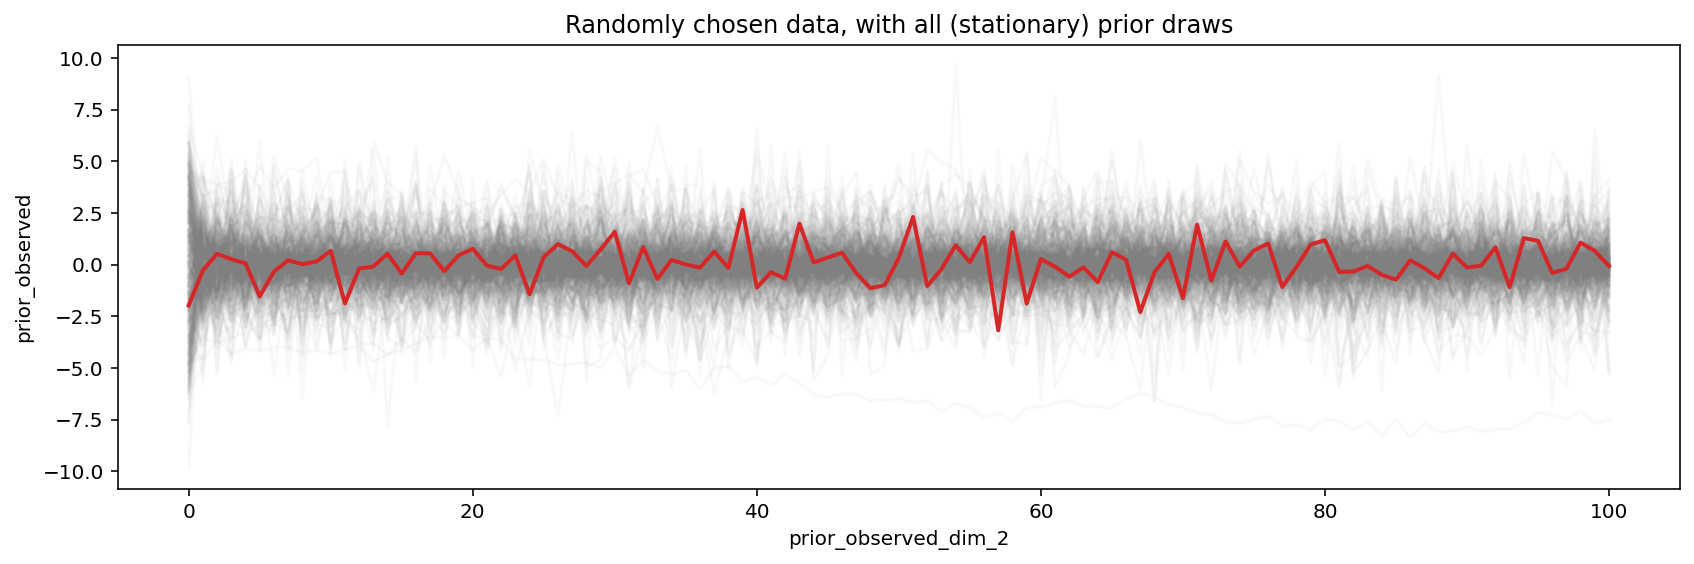

In [22]:
# Choose a sample to model at random from the non-explosive ones
data_idx = rng.choice(stationary_samples.coords["sample"].draw.values)
data = stationary_samples.sel(chain=0, draw=data_idx).values

fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
(
    stationary_samples.sel(prior_observed_dim_3=0).plot.line(
        x="prior_observed_dim_2", add_legend=False, ax=ax, color="0.5", alpha=0.05
    )
)
ax.plot(data, color="tab:red", lw=2)
ax.set_title("Randomly chosen data, with all (stationary) prior draws")
plt.show()

In [23]:
# Save the true AR parameters and sigma_x to see how well we do recovering them
true_ar = prior.prior.ar_params.sel(chain=0, draw=data_idx).values
true_sigma_x = prior.prior.sigma_x.sel(chain=0, draw=data_idx).values

## Fit the custom AR3 model

In [24]:
ar3 = AutoRegressiveThree()

with pm.Model() as pymc_mod:
    x0 = pm.Deterministic(
        "x0",
        pt.zeros(
            3,
        ),
    )
    P0 = pm.Deterministic("P0", pt.eye(3) * 10)

    ar_params = pm.Normal("ar_params", sigma=0.25, shape=(3,))
    sigma_x = pm.Exponential("sigma_x", 1)

    ar3.build_statespace_graph(data=data, mode="JAX")
    idata = pm.sample(nuts_sampler="numpyro")

/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.529519
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:11.759008
Transforming variables...
Transformation time =  0:00:05.833167


/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/arviz/utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


<Axes: >

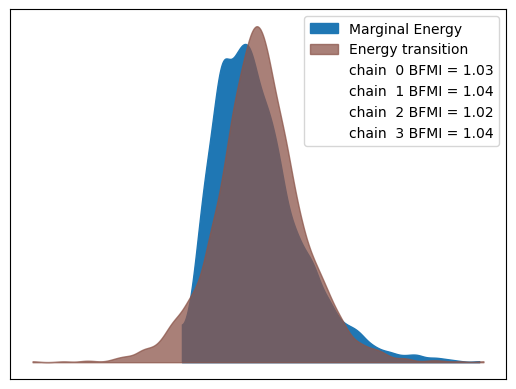

In [25]:
az.plot_energy(idata)

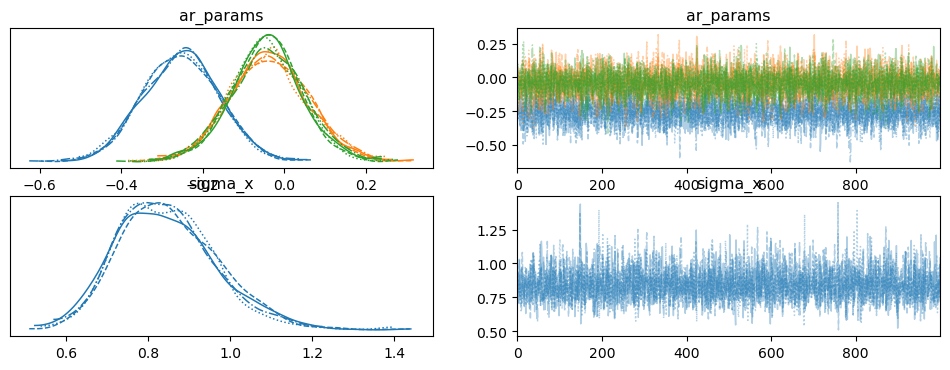

In [26]:
az.plot_trace(idata, var_names=["ar_params", "sigma_x"]);

Estimation goes well, and we recover the true parameters. Just like that!

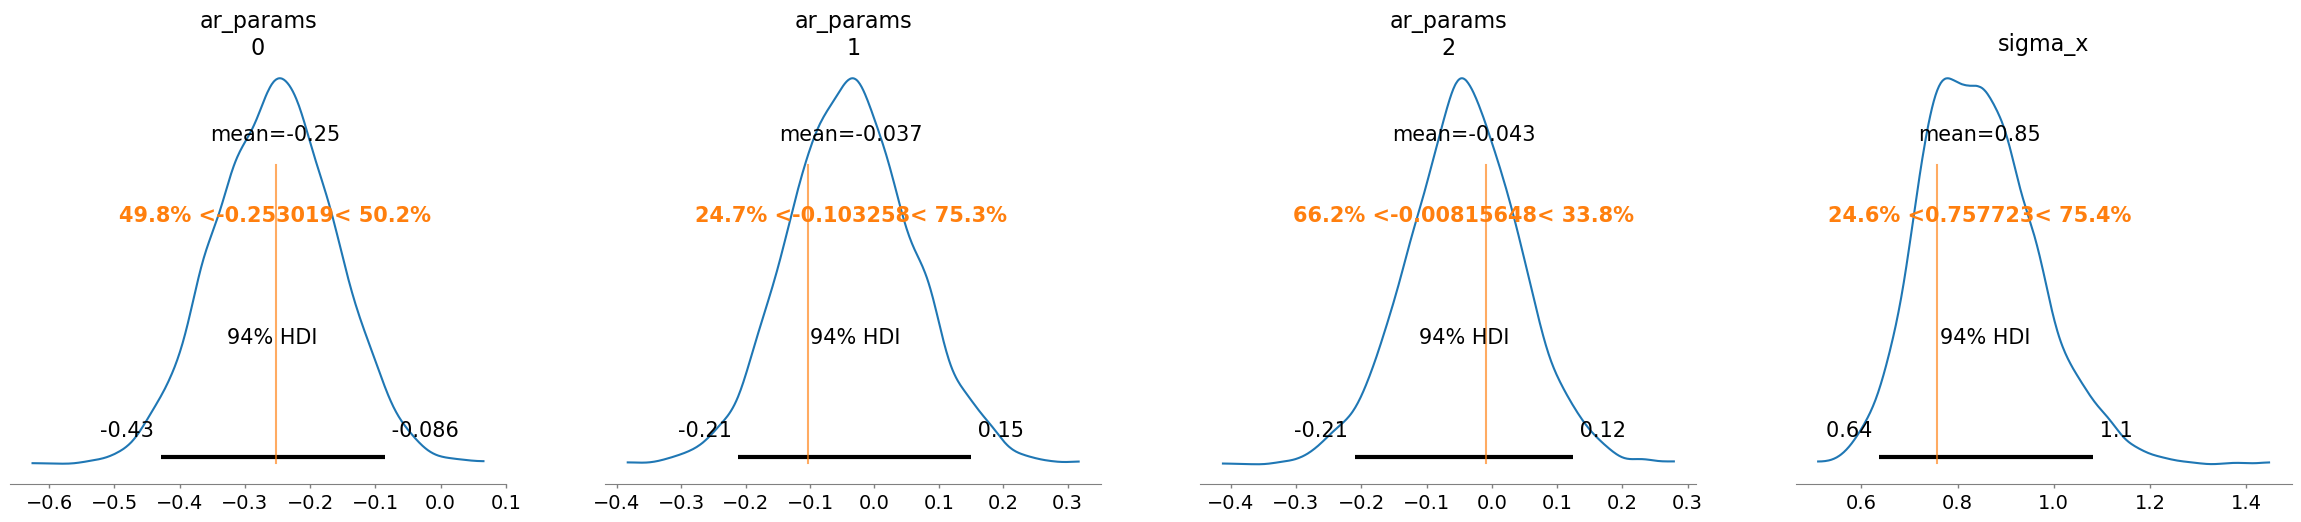

In [27]:
az.plot_posterior(
    idata, var_names=["ar_params", "sigma_x"], ref_val=true_ar.tolist() + [true_sigma_x]
);

## Bells and Whistles

So creating a statespace model is really that simple. All you **need** to do is implement the `__init__` method, `param_names` property, and `update` method.

That said, there are some extra bells and whistles you can optionally set up as well. These are used to set dims and coords on your PyMC model. If you look at the idata we get back from the estimation exercise above, it's pretty horrible. Every statespace object has its own dims, which really makes things look messy.

In [28]:
list(idata.posterior.dims.keys())

['chain',
 'draw',
 'ar_params_dim_0',
 'x0_dim_0',
 'P0_dim_0',
 'P0_dim_1',
 'c_dim_0',
 'd_dim_0',
 'T_dim_0',
 'T_dim_1',
 'Z_dim_0',
 'Z_dim_1',
 'R_dim_0',
 'R_dim_1',
 'H_dim_0',
 'H_dim_1',
 'Q_dim_0',
 'Q_dim_1',
 'filtered_state_dim_0',
 'filtered_state_dim_1',
 'predicted_state_dim_0',
 'predicted_state_dim_1',
 'filtered_covariance_dim_0',
 'filtered_covariance_dim_1',
 'filtered_covariance_dim_2',
 'predicted_covariance_dim_0',
 'predicted_covariance_dim_1',
 'predicted_covariance_dim_2',
 'smoothed_state_dim_0',
 'smoothed_state_dim_1',
 'smoothed_covariance_dim_0',
 'smoothed_covariance_dim_1',
 'smoothed_covariance_dim_2']

In fact, among all these dimensions, there are only 4 dimensions:

1. states
2. observed states
3. shocks
4. time

To let the model know that, we can set the `state_names`, `observed_states`, and  `shock_names` properties. The `param_dims` property maps the names of params to dimensions. Finally, the `coords` property returns a `dims:coords` dictionary for PyMC to use.

The last thing we can implement is the `params_info` property. If it exists, it will be used to show a message after a model is instantiated, telling the user what the param names are, what their shapes are, and any support restrictions the priors need to respect.

Here is the `AutoRegressiveThree` class one last time, with all the bells and whistles implemented.

In [29]:
from pymc_experimental.statespace.utils.constants import (
    ALL_STATE_DIM,
    ALL_STATE_AUX_DIM,
    OBS_STATE_DIM,
    SHOCK_DIM,
)
from pymc_experimental.statespace.models.utilities import make_default_coords


class AutoRegressiveThree(PyMCStateSpace):
    def __init__(self):
        k_states = 3  # size of the state vector x
        k_posdef = 1  # number of shocks (size of the state covariance matrix Q)
        k_endog = 1  # number of observed states

        super().__init__(k_endog=k_endog, k_states=k_states, k_posdef=k_posdef)

        self.ssm["transition", :, :] = np.eye(3, k=-1)
        self.ssm["selection", 0, 0] = 1
        self.ssm["design", 0, 0] = 1

    @property
    def param_names(self):
        return ["x0", "P0", "ar_params", "sigma_x"]

    def update(self, theta, **kwargs):
        x0_params = theta[:3]
        P0_params = theta[3:12]
        ar_params = theta[12:15]
        sigma_x = theta[15]

        self.ssm["initial_state", :] = x0_params
        self.ssm["initial_state_cov", :, :] = P0_params.reshape((3, 3))
        self.ssm["transition", 0, :] = ar_params
        self.ssm["state_cov", 0, 0] = sigma_x

    @property
    def state_names(self):
        # Since the three states are lags of the data, i'll call them L1, L2 L3
        return ["L1.data", "L2.data", "L3.data"]

    @property
    def shock_names(self):
        # There is one shock, called the "innovations" in the literature, so i'll go with that
        return ["innovations"]

    @property
    def observed_states(self):
        # Inspired, I know
        return ["data"]

    @property
    def param_dims(self):
        # This needs to map the 4 parameters to the names of the coords.
        # There are special standardized names to use here. You can import them from
        # pymc_experimental.statespace.utils.constants

        # Not the best system. Something to improve on in the future.
        return {
            "x0": (ALL_STATE_DIM,),
            "P0": (ALL_STATE_DIM, ALL_STATE_AUX_DIM),
            "ar_params": ("ar_lags",),
            "sigma_x": (SHOCK_DIM,),
        }

    @property
    def coords(self):
        # This function puts coords on all those statespace matrices (x0, P0, c, d, T, Z, R, H, Q)
        # and also on the different filter outputs so you don't have to worry about it. You only need to set
        # the coords for the dims unique to your model. In this case, it's just "ar_lags"
        coords = make_default_coords(self)
        coords.update({"ar_lags": [1, 2, 3]})

        return coords

    @property
    def param_info(self):
        # This needs to return a dictionary where the keys are the parameter names, and the values are a
        # dictionary. The value dictionary should have the following keys: "shape", "constraints", and "dims".

        info = {
            "x0": {
                "shape": (self.k_states,),
                "constraints": "None",
            },
            "P0": {
                "shape": (self.k_states, self.k_states),
                "constraints": "Positive Semi-definite",
            },
            "sigma_x": {
                "shape": (self.k_posdef,),
                "constraints": "Positive",
            },
            "ar_params": {
                "shape": (3,),
                "constraints": "None",
            },
        }

        # Lazy way to add the dims without making any typos
        for name in self.param_names:
            info[name]["dims"] = self.param_dims[name]

        return info

Now when we create an `AutoRegressiveThree` model, we get a message telling us how to declare the priors:

In [30]:
ar3 = AutoRegressiveThree()

The following parameters should be assigned priors inside a PyMC model block: 
	x0 -- shape: (3,), constraints: None, dims: ('state',)
	P0 -- shape: (3, 3), constraints: Positive Semi-definite, dims: ('state', 'state_aux')
	sigma_x -- shape: (1,), constraints: Positive, dims: ('shock',)
	ar_params -- shape: (3,), constraints: None, dims: ('ar_lags',)


Let's fit the same model again, this time with coords. When all the default dimensions are found in the model (the ones from `utils.constants`), `build_statespace_graph` will detect that all the coords are properly set up, and it will add a time coord for us automatically from the data.

In our case we passed a numpy array, so we get a warning that time will be a simple range index. If the data is a pandas `DataFrame` or `Series` with a `DateTimeIndex`, we will get that back instead.

In [31]:
with pm.Model(coords=ar3.coords) as pymc_mod:
    x0 = pm.Deterministic(
        "x0",
        pt.zeros(
            3,
        ),
        dims=["state"],
    )
    P0 = pm.Deterministic("P0", pt.eye(3) * 10, dims=["state", "state_aux"])

    ar_params = pm.Normal("ar_params", sigma=0.25, dims=["ar_lags"])
    sigma_x = pm.Exponential("sigma_x", 1, dims=["shock"])

    ar3.build_statespace_graph(data=data, mode="JAX")
    idata = pm.sample(nuts_sampler="numpyro")

/mnt/c/users/jesse/Python Projects/pymc-experimental/notebooks/../pymc_experimental/statespace/utils/data_tools.py:73: UserWarning: No time index found on the supplied data. A simple range index will be automatically generated.
  warnings.warn(NO_TIME_INDEX_WARNING)
/home/jesse/mambaforge/envs/pymc-statespace/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.191193
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:12.096769
Transforming variables...
Transformation time =  0:00:04.225042


As you can see, the posterior now has nice dimensions

In [32]:
print(list(idata.posterior.dims))

['chain', 'draw', 'ar_lags', 'shock', 'state', 'state_aux', 'observed_state', 'observed_state_aux', 'shock_aux', 'time']
